In [1]:
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load preprocessed data
X_train = np.load("X_^NSEI.npy")
Y_train = np.load("Y_^NSEI.npy")
X_test = np.load("X_^NSEI.npy")
Y_test = np.load("Y_^NSEI.npy")

In [3]:
# Ensure correct input dimensions
X_train = jnp.expand_dims(X_train, axis=-1) if X_train.ndim == 2 else X_train
X_test = jnp.expand_dims(X_test, axis=-1) if X_test.ndim == 2 else X_test

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (1172, 60, 1)
Y_train shape: (1172,)


In [4]:
# Convert to JAX arrays
X_train = jnp.array(X_train, dtype=jnp.float32)
Y_train = jnp.array(Y_train, dtype=jnp.float32)
X_test = jnp.array(X_test, dtype=jnp.float32)
Y_test = jnp.array(Y_test, dtype=jnp.float32)

In [12]:

# Define the LSTM model using Flax
class LSTMModel(nn.Module):
    hidden_size: int
    num_layers: int

    @nn.compact
    def __call__(self, x):
        carry = nn.LSTMCell(features=self.hidden_size).initialize_carry(
            jax.random.PRNGKey(0), (x.shape[0], self.hidden_size)  # Fixed carry shape
        )
        outputs = []
        for t in range(x.shape[1]):
            carry, y = nn.LSTMCell(features=self.hidden_size)(carry, x[:, t])
            outputs.append(y)
        lstm_output = jnp.array(outputs).transpose((1, 0, 2))[:, -1, :]  # Take the last output
        return nn.Dense(features=1)(lstm_output).squeeze(-1)  # Add dense layer and squeeze to match Y_train shape


In [13]:
# Initialize model and optimizer
hidden_size = 50
num_layers = 2
model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers)
example_input = jnp.ones((X_train.shape[0], X_train.shape[1], 1))  # Ensure feature_dim=1
params = model.init(jax.random.PRNGKey(0), example_input)
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

In [14]:
# Debugging: Print dataset shape
print("Original X_train shape:", X_train.shape)

# Ensure correct input shape (batch_size, seq_length, feature_dim)
if X_train.ndim == 2:  # (batch_size, seq_length)
    X_train = X_train[..., None]  # Expand last dimension

print("✅ Reshaped X_train shape:", X_train.shape)  # Should be (batch_size, seq_length, 1)


Original X_train shape: (1172, 60, 1)
✅ Reshaped X_train shape: (1172, 60, 1)


In [15]:
# Ensure input dimensions match expected format
example_input = jnp.ones((X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Example batch
params = model.init(jax.random.PRNGKey(0), example_input)
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

In [16]:
# Ensure correct input shape (batch_size, sequence_length, feature_dim)
if X_train.ndim == 2:  # If shape is (batch_size, seq_length), add feature dim
    X_train = X_train[..., None]  # Expand last dimension
elif X_train.ndim == 1:  # If it's 1D, reshape entirely
    X_train = X_train.reshape(-1, 60, 1)  # Example reshape (batch_size, 60, 1)

print("✅ Reshaped X_train shape:", X_train.shape)  # Should be (batch_size, seq_length, 1)


✅ Reshaped X_train shape: (1172, 60, 1)


In [17]:
# Training step function
@jax.jit
def train_step(params, opt_state, X, Y):
    def loss_fn(params):
        predictions = model.apply(params, X)
        loss = jnp.mean((predictions - Y) ** 2)  # Mean Squared Error (MSE)
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss

In [18]:
# Train the model
epochs = 50
loss_history = []

for epoch in range(epochs):
    params, opt_state, loss = train_step(params, opt_state, X_train, Y_train)
    loss_history.append(loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")

Epoch 1/50, Loss: 0.257800
Epoch 2/50, Loss: 0.229052
Epoch 3/50, Loss: 0.202002
Epoch 4/50, Loss: 0.176649
Epoch 5/50, Loss: 0.152996
Epoch 6/50, Loss: 0.131046
Epoch 7/50, Loss: 0.110804
Epoch 8/50, Loss: 0.092282
Epoch 9/50, Loss: 0.075499
Epoch 10/50, Loss: 0.060481
Epoch 11/50, Loss: 0.047258
Epoch 12/50, Loss: 0.035863
Epoch 13/50, Loss: 0.026325
Epoch 14/50, Loss: 0.018667
Epoch 15/50, Loss: 0.012891
Epoch 16/50, Loss: 0.008967
Epoch 17/50, Loss: 0.006804
Epoch 18/50, Loss: 0.006234
Epoch 19/50, Loss: 0.006975
Epoch 20/50, Loss: 0.008631
Epoch 21/50, Loss: 0.010714
Epoch 22/50, Loss: 0.012728
Epoch 23/50, Loss: 0.014271
Epoch 24/50, Loss: 0.015100
Epoch 25/50, Loss: 0.015155
Epoch 26/50, Loss: 0.014514
Epoch 27/50, Loss: 0.013343
Epoch 28/50, Loss: 0.011844
Epoch 29/50, Loss: 0.010210
Epoch 30/50, Loss: 0.008604
Epoch 31/50, Loss: 0.007148
Epoch 32/50, Loss: 0.005915
Epoch 33/50, Loss: 0.004942
Epoch 34/50, Loss: 0.004230
Epoch 35/50, Loss: 0.003758
Epoch 36/50, Loss: 0.003489
E

In [20]:
# Save the trained model
with open("models/trained_lstm_model.pkl", "wb") as f:
    import pickle
    pickle.dump(params, f)

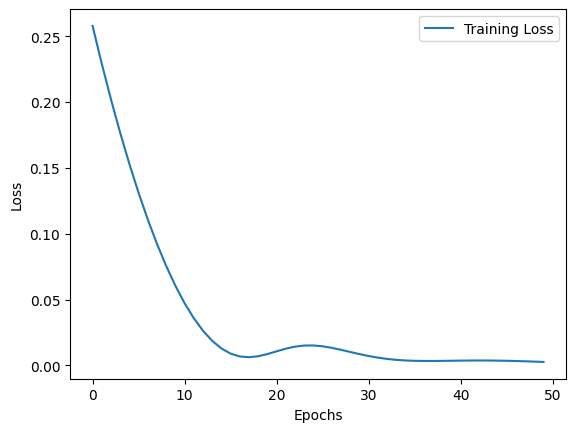

✅ Model Training Complete! Model saved as 'trained_lstm_model.pkl'


In [22]:
# Plot training loss
plt.plot(range(epochs), loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("results/loss_plot.png")
plt.show()

print("✅ Model Training Complete! Model saved as 'trained_lstm_model.pkl'")